# Code for Section 6.4 Parameter uncertainty and Exposure Stacking
The example below replicated the Exposure Stacking analysis from https://ssrn.com/abstract=4709317 for a different seed and includes the analysis metioned in Section 2.1 from the article to illustrate that stacking based on the portfolio mean or portfolio volatility causes a significant risk and return drift.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from copy import copy

In [2]:
# Load instrument info
instrument_names, means, covariance_matrix = ft.load_parameters()

In [3]:
# Specify base long-only constraints
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [4]:
# Parameter uncertainty specification
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(0)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [5]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

In [6]:
# Mean uncertainty
frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)
for b in range(B):
    means_run = np.mean(return_sim[:, b, :], axis=0)
    mv_opt._expected_return_row = -matrix(means_run).T
    frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
    mean_results[:, 0, b] = means_run @ frontier_mean[:, :, b]
    for p in range(P):
        mean_results[p, 1, b] = frontier_mean[:, p, b] @ np.cov(return_sim[:, b, :], rowvar=False) @ frontier_mean[:, p, b]
mv_opt._expected_return_row = -matrix(means).T  # Reset means

In [7]:
def resampled_stacking(L, sample_targets):
    """Computes the L-fold Resampled Portfolio Stacking sample weights.

    Args:
        L: Number of partition sets.
        sample_targets: Sample portfolio exposures with shape (I, B) or (1, B).

    Returns:
        Stacking sample weights.
    """
    B = sample_targets.shape[1]
    partition_size = B // L  # size of validation set for all except possibly the last
    indices = np.arange(0, B)
    partitions = [indices[l * partition_size:(l + 1) * partition_size] for l in range(L - 1)]
    partitions.append(indices[(L - 1) * partition_size:])

    M = sample_targets.T
    P = np.zeros((B, B))
    q = np.zeros((B, 1))
    for K_l in partitions:
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(sample_targets[:, K_l], axis=1)
        q = q + len(K_l)**-1 * (M_l @ sum_exposures_K_l)[:, np.newaxis]

    P = matrix(2 * P)
    q = matrix(-2 * q)
    A = matrix(np.ones((1, B)))
    b = matrix(np.array([[1.]]))
    G = matrix(-np.identity(B))
    h = matrix(np.zeros((B, 1)))
    w = solvers.qp(P, q, G, h, A, b)['x']
    return np.array(w)

In [8]:
# Compute portfolios for the middle index using the different approaches
L = 10
pf_index = 4
pf_frontier = frontier[:, pf_index]
pf_re = np.mean(frontier_mean[:, pf_index, :], axis=1)
pf_es = ft.exposure_stacking(L, frontier_mean[:, pf_index, :])
w_mean = resampled_stacking(L, mean_results[pf_index, :, :][0, np.newaxis])
pf_mean = frontier_mean[:, pf_index, :] @ w_mean
w_vol = resampled_stacking(L, np.sqrt(mean_results[pf_index, :, :][1, np.newaxis]))
pf_vol = frontier_mean[:, pf_index, :] @ w_vol
w_mean_vol = resampled_stacking(L, (mean_results[pf_index, 0, :] / np.sqrt(mean_results[pf_index, 1, :])[:, np.newaxis]))
pf_mean_vol = frontier_mean[:, pf_index, :] @ w_mean_vol

In [9]:
# Results Table 6.2
pf_results = np.vstack((pf_re, pf_es, pf_mean[:, 0], pf_vol[:, 0], pf_mean_vol[:, 0], pf_frontier)).T
pf_means = means @ pf_results
pf_vols = np.full(pf_results.shape[1], np.nan)
for i in range(len(pf_vols)):
    pf_vols[i] = np.sqrt(pf_results[:, i].T @ covariance_matrix @ pf_results[:, i])
pf_results2 = np.vstack((pf_results, pf_means[np.newaxis, :], pf_vols[np.newaxis, :]))
pf_df = pd.DataFrame(
    np.round(100 * pf_results2, 2), index=instrument_names + ['Mean'] + ['Vol'], 
    columns=['Resampled', 'Exposure', 'Mean', 'Volatility', 'Mean / Volatility', 'Frontier'])
pf_df

,Resampled,Exposure,Mean,Volatility,Mean / Volatility,Frontier
Gov & MBS,0.12,0.00,0.06,0.05,0.03,0.00
Corp IG,0.00,0.00,0.00,0.00,0.00,0.00
Corp HY,0.00,0.00,0.00,0.00,0.00,0.00
EM Debt,4.88,3.35,4.33,6.82,4.60,0.00
DM Equity,0.48,0.00,0.45,0.36,0.48,0.00
EM Equity,0.07,0.00,0.05,0.05,0.05,0.00
Private Equity,18.07,17.97,20.15,22.71,20.72,20.41
Infrastructure,34.35,36.07,33.17,30.33,33.19,40.49
Real Estate,16.36,16.16,14.48,14.57,14.98,11.06
Hedge Funds,25.66,26.46,27.31,25.12,25.95,28.04


# Out-of-sample testing

In [10]:
# Out-of-sample simulations
return_sim_oos = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [11]:
def risk_return(pf):
    """Computes the out of sample risk and return of the portfolio.

    Args:
        pf: Portfolio to measure risk and return against.

    Returns:
        Array of shape (2, B) with risk and return for each of the B simulations.
    """
    risk_return = np.full((2, B), np.nan)
    for b in range(B):
        means_run = np.mean(return_sim_oos[:, b, :], axis=0)
        cov_run = np.cov(return_sim_oos[:, b, :], rowvar=False)
        risk_return[0, b] = pf @ cov_run @ pf
        risk_return[1, b] = means_run @ pf
    return risk_return

In [12]:
re_rr = risk_return(pf_re)
re_rar = re_rr[1, :] / re_rr[0, :]
es_rr = risk_return(pf_es)
es_rar = es_rr[1, :] / es_rr[0, :]
return_rr = risk_return(pf_mean[:, 0])
return_rar = return_rr[1, :] / return_rr[0, :]
vol_rr = risk_return(pf_vol[:, 0])
vol_rar = vol_rr[1, :] / vol_rr[0, :]
mean_vol_rr = risk_return(pf_mean_vol[:, 0])
mean_vol_rar = mean_vol_rr[1, :] / mean_vol_rr[0, :]
frontier_rr = risk_return(frontier[:, pf_index])
frontier_rar = frontier_rr[1, :] / frontier_rr[0, :]

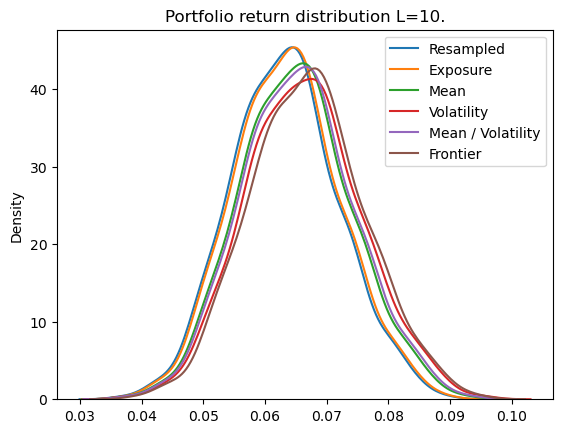

In [13]:
# Return
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=es_rr[1, :])
sns.kdeplot(x=return_rr[1, :])
sns.kdeplot(x=vol_rr[1, :])
sns.kdeplot(x=mean_vol_rr[1, :])
sns.kdeplot(x=frontier_rr[1, :])
plt.title(f'Portfolio return distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Mean', 'Volatility', 'Mean / Volatility', 'Frontier'])
plt.show()

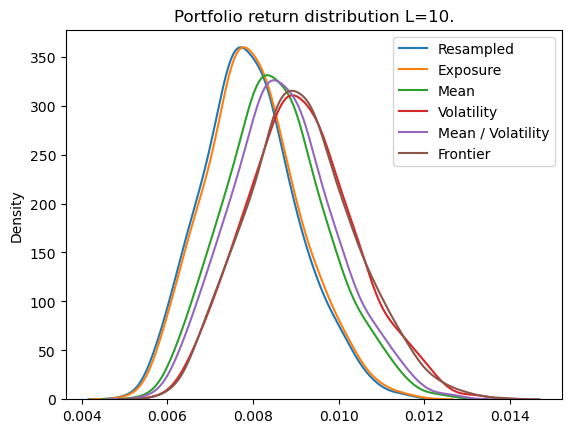

In [14]:
# Variance
sns.kdeplot(x=re_rr[0, :])
sns.kdeplot(x=es_rr[0, :])
sns.kdeplot(x=return_rr[0, :])
sns.kdeplot(x=vol_rr[0, :])
sns.kdeplot(x=mean_vol_rr[0, :])
sns.kdeplot(x=frontier_rr[0, :])
plt.title(f'Portfolio return distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Mean', 'Volatility', 'Mean / Volatility', 'Frontier'])
plt.show()

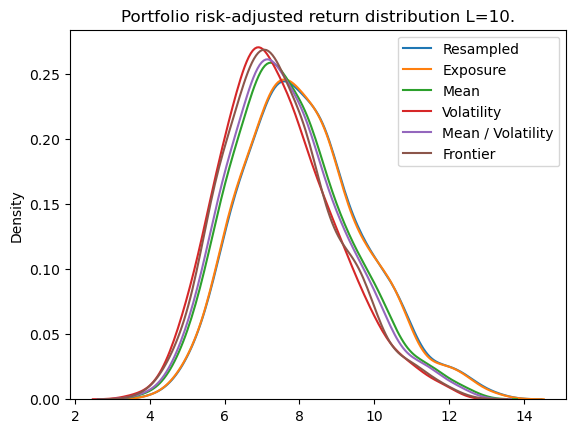

In [15]:
# Variance-adjusted return
sns.kdeplot(x=re_rar)
sns.kdeplot(x=es_rar)
sns.kdeplot(x=return_rar)
sns.kdeplot(x=vol_rar)
sns.kdeplot(x=mean_vol_rar)
sns.kdeplot(x=frontier_rar)
plt.title(f'Portfolio risk-adjusted return distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Mean', 'Volatility', 'Mean / Volatility', 'Frontier'])
plt.show()